# Imports

In [4]:
# PyCBC Imports
from pycbc import distributions
from pycbc.waveform import get_td_waveform
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
import pycbc.psd
import pycbc.noise

# GWPy Imports
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps

# Standard Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import csv

# Other Libraries
from tqdm.notebook import tqdm
import pylab

# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# LALSuite (for gravitational wave analysis)
import lal

In [ ]:
directory = "Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/LIGO-Detector-Data/"

# BBH Merger Strain Data Download

In [6]:
bbh_events = ['GW150914',
              'GW151012',
              'GW151226',
              'GW170104',
              'GW170608',
              'GW170729',
              'GW170809',
              'GW170814',
              'GW170818',
              'GW170823',
              'GW190408_181802',
              'GW190412',              
              'GW190413_052954',
              'GW190413_134308',
              'GW190421_213856',
              'GW190424_180648',
              'GW190425',
              'GW190503_185404',
              'GW190512_180714',
              'GW190513_205428',
              'GW190514_065416',
              'GW190517_055101',
              'GW190519_153544',
              'GW190521',
              'GW190521_074359',
              'GW190527_092055',
              'GW190602_175927',
              'GW190620_030421',
              'GW190630_185205',
              'GW190701_203306',
              'GW190706_222641',
              'GW190707_093326',
              'GW190708_232457',
              'GW190719_215514',
              'GW190720_000836',
              'GW190727_060333',
              'GW190728_064510',
              'GW190731_140936',
              'GW190803_022701',
              'GW190814',
              'GW190828_063405',
              'GW190828_065509',
              'GW190909_114149',
              'GW190910_112807',
              'GW190915_235702',
              'GW190924_021846',
              'GW190929_012149',
              'GW190930_133541']

In [ ]:
import os
from gwpy.timeseries import TimeSeries
from tqdm import tqdm

# Define your directory path
directory = "Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/LIGO-Detector-Data/"

# Ensure the destination directory exists
os.makedirs(directory + "BBH-mergers/Original-signals/", exist_ok=True)

# Loop through the BBH events
for i in tqdm(range(len(bbh_events))):
    # Fetch the GPS start and end times for each event
    gps = event_gps(bbh_events[i])  # Assume this function fetches the correct GPS time
    start = int(gps) - 15  # Start time for data fetch (15 seconds before event)
    end = int(gps) + 15  # End time for data fetch (15 seconds after event)

    # Fetch the data from the GWOSC server for L1 detector
    data = TimeSeries.fetch_open_data('L1', start, end)

    # Define the file path to save the data
    file_path = directory + "BBH-mergers/Original-signals/" + bbh_events[i] + ".txt"
    
    # Write the strain data to the specified file
    data.write(file_path)

100%|██████████| 48/48 [02:41<00:00,  3.36s/it]


In [ ]:
import os
import csv
import pandas as pd
from tqdm import tqdm

# Define the directory where the data is stored
directory = "Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/LIGO-Detector-Data/"

# Correct the path to the "BBH-mergers" directory
path = directory + "BBH-mergers/Original-signals/"

# Check if the directory exists
if not os.path.exists(path):
    print(f"The directory {path} does not exist. Please check the path or create the directory.")
else:
    # Get the list of files in the directory
    files = os.listdir(path)
    
    # Define the output CSV file
    output_file = directory + 'BBH-mergers/Original_BBH_Merged.csv'
    
    # Open the output CSV file to write merged data
    with open(output_file, 'w', newline='') as f:
        cw = csv.writer(f)

        # Loop through the files and process them
        for i in tqdm(files):
            file_path = os.path.join(path, i)
            
            # Check if the file is a valid file (not a subdirectory)
            if os.path.isfile(file_path):
                df = pd.read_csv(file_path, sep=' ', header=None)
                c = df[:][1]  # Get the second column (strain data)
                cw.writerow(c)  # Write to CSV
            else:
                print(f"Skipping {i} as it is not a valid file.")

100%|██████████| 48/48 [00:05<00:00,  8.23it/s]


In [9]:
# Processed strain data

for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    
    data = TimeSeries.read(directory + "BBH-mergers/Original-signals/"+bbh_events[i]+".txt")    
    data = TimeSeries.to_pycbc(data)
    data = data.whiten(4, 4)
    data = data.highpass_fir(30, 512).lowpass_fir(250, 512)
    data = data.time_slice(gps - 2, gps + 2)
    
    data = TimeSeries.from_pycbc(data)
    data.write(directory + "BBH-mergers/Processed-signals/"+bbh_events[i]+".txt")    
    

100%|██████████| 48/48 [00:05<00:00,  9.17it/s]


In [10]:
# Merging Processed Strain Data Templates into single file

path = directory + "BBH-mergers/Processed-signals/"
files= os.listdir(path)
f = open(directory + 'BBH-mergers/Processed_BBH_Merged.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 48/48 [00:00<00:00, 71.48it/s]


In [11]:
# Another way of processing the strain data
# Scaled Processed strain data

for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    
    data = TimeSeries.read(directory + "BBH-mergers/Original-signals/"+bbh_events[i]+".txt")    
    data = TimeSeries.to_pycbc(data)
    data = data.whiten(4, 4)
    data = data.highpass_fir(30, 512).lowpass_fir(250, 512)
    data = data.time_slice(gps - 2, gps + 2)
    
    data = TimeSeries.from_pycbc(data)
    data = (data/(max(data.max(), np.abs(data.min()))))*1.25
    data *= 0.4
    data *= 1e-17

    data.write(directory + "BBH-mergers/Scaled-Processed-signals/"+bbh_events[i]+".txt")    
    

100%|██████████| 48/48 [00:05<00:00,  9.18it/s]


In [12]:
# Merging Scaled Processed Strain Data Templates into single file

path = directory + "BBH-mergers/Scaled-Processed-signals/"
files= os.listdir(path)
f = open(directory + 'BBH-mergers/Scaled_Processed_BBH_Merged.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 48/48 [00:00<00:00, 56.69it/s]


In [13]:
# Another way of processing the strain data
## Scaled Sliced strain data

for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    
    data = TimeSeries.read(directory + "BBH-mergers/Original-signals/"+bbh_events[i]+".txt")    
    data = TimeSeries.to_pycbc(data)
    data = data.time_slice(gps - 2, gps + 2)
    
    data = TimeSeries.from_pycbc(data)
    data = (data/(max(data.max(), np.abs(data.min()))))*1.25
    data *= 0.4
    data *= 1e-17

    data.write(directory + "BBH-mergers/Scaled-Sliced-signals/"+bbh_events[i]+".txt")    
    

100%|██████████| 48/48 [00:03<00:00, 13.47it/s]


In [14]:
# Merging Scaled Sliced Strain Data Templates into single file

path = directory + "BBH-mergers/Scaled-Sliced-signals/"
files= os.listdir(path)
f = open(directory + 'BBH-mergers/Scaled_Sliced_BBH_Merged.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 48/48 [00:00<00:00, 59.06it/s]


In [15]:
# Another way of processing the strain data
## Sliced strain data

for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    
    data = TimeSeries.read(directory + "BBH-mergers/Original-signals/"+bbh_events[i]+".txt")    
    data = TimeSeries.to_pycbc(data)
    data = data.time_slice(gps - 2, gps + 2)
    
    data = TimeSeries.from_pycbc(data)

    data.write(directory + "BBH-mergers/Sliced-signals/"+bbh_events[i]+".txt")    
    

100%|██████████| 48/48 [00:03<00:00, 13.71it/s]


In [16]:
# Merging Sliced Strain Data Templates into single file

path = directory + "BBH-mergers/Sliced-signals/"
files= os.listdir(path)
f = open(directory + 'BBH-mergers/Sliced_BBH_Merged.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 48/48 [00:00<00:00, 60.78it/s]


  4%|▍         | 2/48 [00:00<00:06,  7.18it/s]

4096.0 Hz
4096.0 Hz


  8%|▊         | 4/48 [00:00<00:05,  8.19it/s]

4096.0 Hz
4096.0 Hz


 12%|█▎        | 6/48 [00:00<00:04,  8.49it/s]

4096.0 Hz
4096.0 Hz


 17%|█▋        | 8/48 [00:00<00:04,  8.33it/s]

4096.0 Hz
4096.0 Hz


 21%|██        | 10/48 [00:01<00:04,  8.73it/s]

4096.0 Hz
4096.0 Hz


 25%|██▌       | 12/48 [00:01<00:04,  8.96it/s]

4096.0 Hz
4096.0 Hz


 29%|██▉       | 14/48 [00:01<00:03,  9.09it/s]

4096.0 Hz
4096.0 Hz


 31%|███▏      | 15/48 [00:01<00:03,  8.83it/s]

4096.0 Hz


 38%|███▊      | 18/48 [00:02<00:03,  8.07it/s]

4096.0 Hz
4096.0 Hz


 42%|████▏     | 20/48 [00:02<00:03,  8.65it/s]

4096.0 Hz
4096.0 Hz


 46%|████▌     | 22/48 [00:02<00:02,  8.94it/s]

4096.0 Hz
4096.0 Hz


 50%|█████     | 24/48 [00:02<00:02,  8.71it/s]

4096.0 Hz
4096.0 Hz


 54%|█████▍    | 26/48 [00:03<00:02,  8.79it/s]

4096.0 Hz
4096.0 Hz


 58%|█████▊    | 28/48 [00:03<00:02,  9.05it/s]

4096.0 Hz
4096.0 Hz


 62%|██████▎   | 30/48 [00:03<00:02,  8.99it/s]

4096.0 Hz
4096.0 Hz


 67%|██████▋   | 32/48 [00:03<00:01,  9.08it/s]

4096.0 Hz
4096.0 Hz


 71%|███████   | 34/48 [00:03<00:01,  9.00it/s]

4096.0 Hz
4096.0 Hz


 75%|███████▌  | 36/48 [00:04<00:01,  9.06it/s]

4096.0 Hz
4096.0 Hz


 79%|███████▉  | 38/48 [00:04<00:01,  9.06it/s]

4096.0 Hz
4096.0 Hz


 83%|████████▎ | 40/48 [00:04<00:00,  8.69it/s]

4096.0 Hz
4096.0 Hz


 88%|████████▊ | 42/48 [00:04<00:00,  8.94it/s]

4096.0 Hz
4096.0 Hz


 92%|█████████▏| 44/48 [00:05<00:00,  9.01it/s]

4096.0 Hz
4096.0 Hz


 96%|█████████▌| 46/48 [00:05<00:00,  8.92it/s]

4096.0 Hz
4096.0 Hz


100%|██████████| 48/48 [00:05<00:00,  8.68it/s]

4096.0 Hz
4096.0 Hz


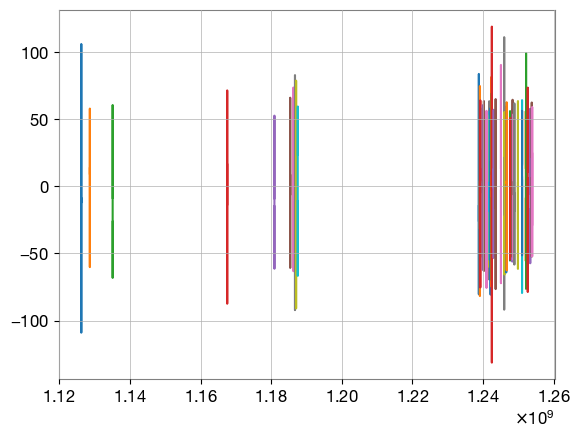

In [17]:
# Test data for hidden, not whitened, test 6, rescaled 0.2

for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    
    data = TimeSeries.read(directory + "BBH-mergers/Original-signals/" + bbh_events[i] + ".txt")    

    if bbh_events[i] == 'GW190424_180648':
        data.write(directory + "BBH-mergers/Processed-signals/" + bbh_events[i] + ".txt")
        continue
    
    data = TimeSeries.to_pycbc(data)

    data = resample_to_delta_t(highpass(data, 15.0), 1.0/4096)
    data = data.whiten(4, 4)
    data = data.highpass_fir(30, 512).lowpass_fir(250, 512)
    
    data = data.time_slice(gps - 2, gps + 2)
    data.plot()
    data = TimeSeries.from_pycbc(data)
    print(data.sample_rate)
    data.write(directory + "BBH-mergers/Processed-signals/" + bbh_events[i] + ".txt")    

# Visualization

4096.0 Hz


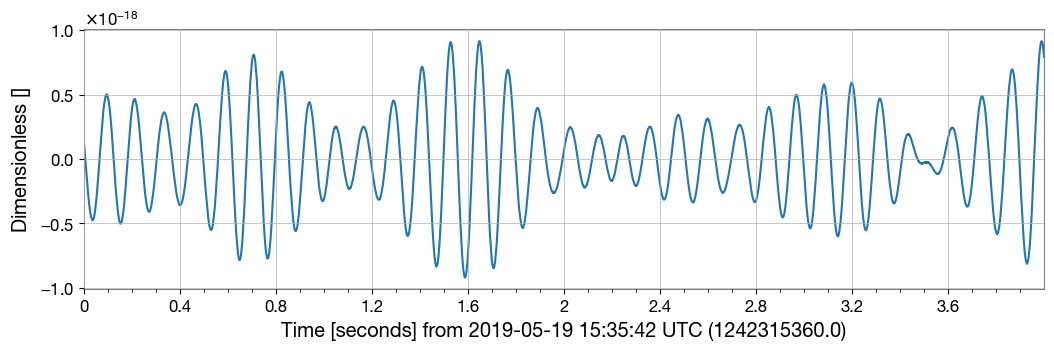

In [18]:
# Visualization of the Original Strain Data
# Duration of the data is 4s, i.e. a 2s interval around the merger

gps = event_gps("GW190519_153544")
start = int(gps) - 2
end = int(gps) + 2
data = TimeSeries.fetch_open_data('L1', start, end)
data.plot()
print(data.sample_rate)

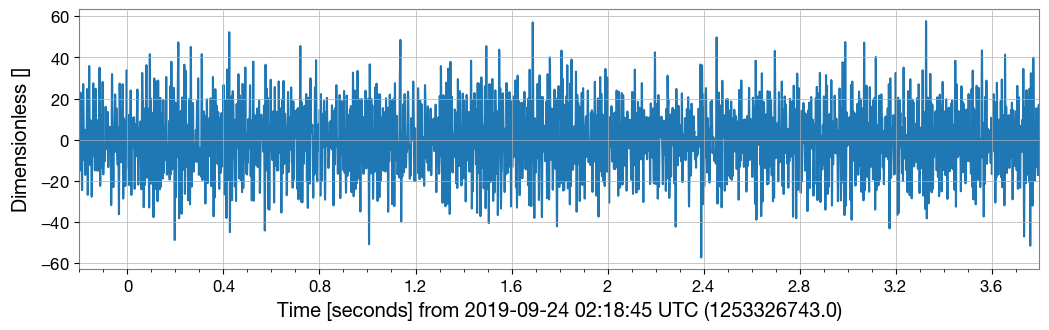

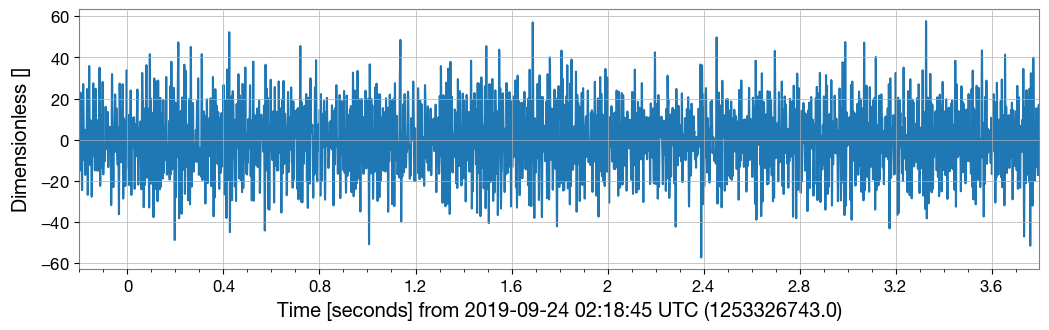

In [19]:
# Visualization of the Processed Strain Data
# Duration of the data is 4s, i.e. a 2s interval around the merger

i = 45
data = TimeSeries.read(directory + "BBH-mergers/Processed-signals/"+bbh_events[i]+".txt")
data.plot()

In [ ]:
for i in tqdm(range(len(bbh_events))):

    gps = event_gps(bbh_events[i])
    start = int(gps) - 2
    end = int(gps) + 2

    data = TimeSeries.fetch_open_data('L1', start, end)
    data.write("/Gravitational-Wave-Detection-Using-Deep-Learning/LIGO-Detector-Data/BBH-mergers/Original-signals/" + bbh_events[i] + ".txt")

100%|██████████| 48/48 [02:34<00:00,  3.22s/it]


In [ ]:
for i in tqdm(range(len(bbh_events))):

    m = Merger(bbh_events[i])
    data = m.strain('L1')

    data1 = TimeSeries.from_pycbc(data)
    data1.write("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/LIGO-Detector-Data/BBH-mergers/Original-signals/" + bbh_events[i] + ".txt")    

    data = data.whiten(4, 4)
    data = data.highpass_fir(30, 512).lowpass_fir(250, 512)
    data = data.time_slice(m.time - 2, m.time + 2)
    data = TimeSeries.from_pycbc(data)
    
    data.write("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/LIGO-Detector-Data/BBH-mergers/Processed-signals/" + bbh_events[i] + ".txt")

100%|██████████| 48/48 [00:13<00:00,  3.44it/s]


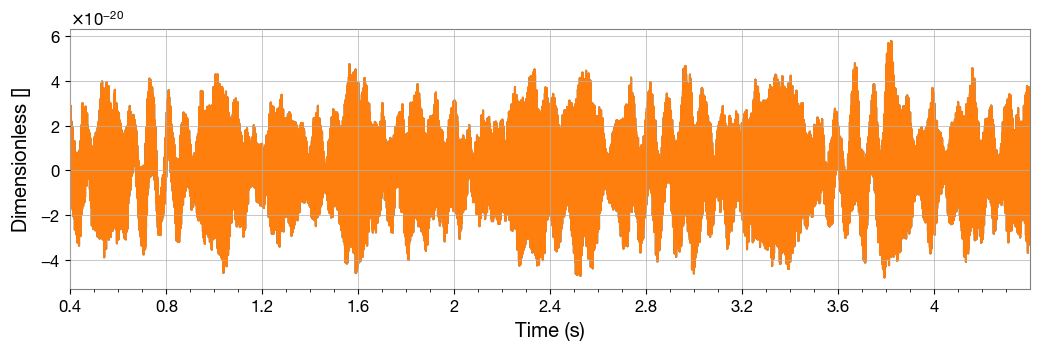

In [22]:
#  Alternate

# As an example we use the GW150914 data
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")

# # Get the data from the Hanford detector
strain = merger.strain('H1')

# # Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/4096)
strain = strain.time_slice(merger.time - 2, merger.time + 2)

data = TimeSeries.from_pycbc(strain)
data.plot()
print()

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

In [ ]:
########################################################
########### BNS Merger Strain Data Download ############
########################################################

# BNS Merger Strain Data Download

In [23]:
bns_events = ['GW170817', 'GW190425']

In [24]:
# Code to fetch strain data from GWOSC server

for i in tqdm(range(len(bns_events))):

    gps = event_gps(bns_events[i])
    start = int(gps) - 15
    end = int(gps) + 15

    data = TimeSeries.fetch_open_data('L1', start, end)

    data.write(directory + "BNS-mergers/Original-signals/"+bns_events[i]+".txt")    

100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


In [25]:
# Merging Original Strain Data Templates into single file

path = directory + "BNS-mergers/Original-signals/"
files= os.listdir(path)
f = open(directory + 'BNS-mergers/Original_BNS_Merged.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 2/2 [00:00<00:00,  7.80it/s]


In [26]:
# Processed strain data

for i in tqdm(range(len(bns_events))):
    gps = event_gps(bns_events[i])
    
    data = TimeSeries.read(directory + "BNS-mergers/Original-signals/"+bns_events[i]+".txt")    
    data = TimeSeries.to_pycbc(data)
    data = data.whiten(4, 4)
    data = data.highpass_fir(30, 512).lowpass_fir(250, 512)
    data = data.time_slice(gps - 2, gps + 2)
    
    data = TimeSeries.from_pycbc(data)
    data.write(directory + "BNS-mergers/Processed-signals/"+bns_events[i]+".txt")    
    

100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


In [27]:
# Merging Processed Strain Data Templates into single file

path = directory + "BNS-mergers/Processed-signals/"
files= os.listdir(path)
f = open(directory + 'BNS-mergers/Processed_BNS_Merged.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 2/2 [00:00<00:00, 47.65it/s]


In [28]:
# Another way of processing the strain data
# Scaled Processed strain data

for i in tqdm(range(len(bns_events))):
    gps = event_gps(bns_events[i])
    
    data = TimeSeries.read(directory + "BNS-mergers/Original-signals/"+bns_events[i]+".txt")    
    data = TimeSeries.to_pycbc(data)
    data = data.whiten(4, 4)
    data = data.highpass_fir(30, 512).lowpass_fir(250, 512)
    data = data.time_slice(gps - 2, gps + 2)
    
    data = TimeSeries.from_pycbc(data)
    data = (data/(max(data.max(), np.abs(data.min()))))*1.25
    data *= 0.4
    data *= 1e-17

    data.write(directory + "BNS-mergers/Scaled-Processed-signals/"+bns_events[i]+".txt")    
    

100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


In [29]:
# Merging Scaled Processed Strain Data Templates into single file

path = directory + "BNS-mergers/Scaled-Processed-signals/"
files= os.listdir(path)
f = open(directory + 'BNS-mergers/Scaled_Processed_BNS_Merged.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 2/2 [00:00<00:00, 36.41it/s]


In [30]:
# Another way of processing the strain data
## Scaled Sliced strain data

for i in tqdm(range(len(bns_events))):
    gps = event_gps(bns_events[i])
    
    data = TimeSeries.read(directory + "BNS-mergers/Original-signals/"+bns_events[i]+".txt")    
    data = TimeSeries.to_pycbc(data)
    data = data.time_slice(gps - 2, gps + 2)
    
    data = TimeSeries.from_pycbc(data)
    data = (data/(max(data.max(), np.abs(data.min()))))*1.25
    data *= 0.4
    data *= 1e-17

    data.write(directory + "BNS-mergers/Scaled-Sliced-signals/"+bns_events[i]+".txt")    
    

100%|██████████| 2/2 [00:00<00:00, 11.49it/s]


In [31]:
# Merging Scaled Sliced Strain Data Templates into single file

path = directory + "BNS-mergers/Scaled-Sliced-signals/"
files= os.listdir(path)
f = open(directory + 'BNS-mergers/Scaled_Sliced_BNS_Merged.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 2/2 [00:00<00:00, 32.71it/s]


100%|██████████| 2/2 [00:00<00:00, 11.46it/s]


4096.0 Hz
4096.0 Hz


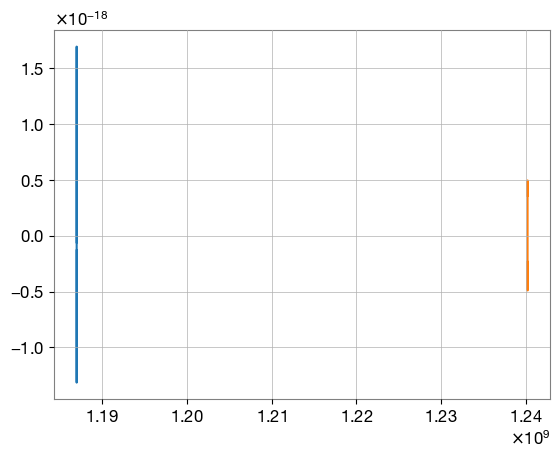

In [ ]:
# Test data for hidden, not whitened, test 6, rescaled 0.2
for i in tqdm(range(len(bns_events))):
    gps = event_gps(bns_events[i])
    data = TimeSeries.read("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/LIGO-Detector-Data/BNS-mergers/Original-signals/"+bns_events[i]+".txt")
    data = TimeSeries.to_pycbc(data)
    data = data.time_slice(gps - 2, gps + 2)
    data.plot()
    data = TimeSeries.from_pycbc(data)
    print(data.sample_rate)
    
    data.write("Downloads/Gravitational-Wave-Detection-Using-Deep-Learning/LIGO-Detector-Data/BNS-mergers/Processed-signals/"+bns_events[i]+".txt")

# Visualization

4096.0 Hz


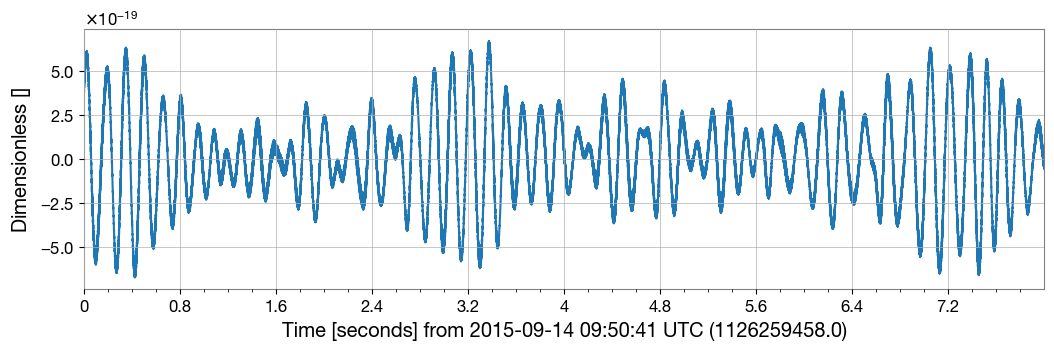

In [33]:
# Visualization of the Original Strain Data
# Duration of the data is 4s, i.e. a 2s interval around the merger

gps = event_gps("GW150914")
start = int(gps) - 4
end = int(gps) + 4
data = TimeSeries.fetch_open_data('H1', start, end)
data.plot()
print(data.sample_rate)

# Extra Noise Samples

In [34]:
# Generate 24 noise samples

for i in tqdm(range(24)):
    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    # Generate 4 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(4 / delta_t)
    noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd)

    noise *= 1e21
    noise *= 0.4
    noise = TimeSeries.from_pycbc(noise)

    noise *= 1e-17
    noise.write(directory + "BBH-mergers/Noise/noise_"+str(i)+".txt")
    

100%|██████████| 24/24 [00:01<00:00, 20.01it/s]


In [35]:
# Merging Noise Data Templates into single file

path = directory + "BBH-mergers/Noise/"
files= os.listdir(path)
f = open(directory + 'BBH-mergers/Noise.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

100%|██████████| 24/24 [00:00<00:00, 57.38it/s]


1126259462.4


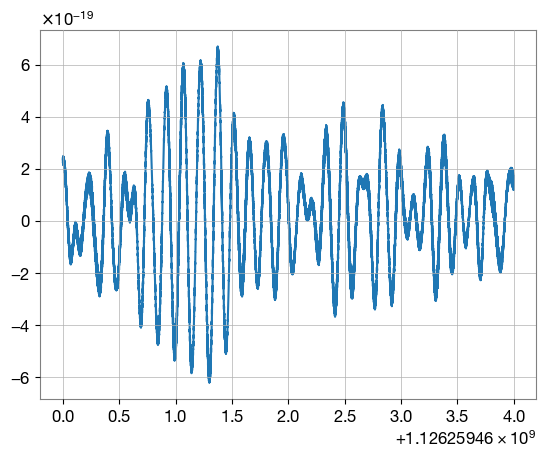

In [36]:
gps = event_gps("GW150914")
print(gps)
start = int(gps) - 2
end = int(gps) + 2

data = TimeSeries.fetch_open_data('H1', start, end)
plt.plot(data)